<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.patches import Polygon
import seaborn as sns
import scipy as sp
from scipy import signal
from scipy.interpolate import griddata
from datetime import timedelta, datetime

In [3]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch

# Importing Data

## Importing Hourly Resolution Data

### Obtaining Longitudes and Latitudes from All Stations

We start by reading the first two lines of the data file to obtain the longitude and latitude information of the stations. We zip them together into a list of tuples, and add an element to the beginning of this list corresponding to the time.

In [4]:
lon_and_lat = np.genfromtxt('AllStations_temperature_h_2017.dat', delimiter=" ", max_rows=2)
hour_longitudes = lon_and_lat[0][~np.isnan(lon_and_lat[0])]
hour_latitudes = lon_and_lat[1][~np.isnan(lon_and_lat[1])]

indices = list(zip(hour_longitudes, hour_latitudes))
indices.insert(0, "time")
station_num_to_location = dict(zip(np.arange(0,37), indices[1::]))

## Importing Minute Resolution Data

In [5]:
min_longitudes = np.array([236.543, 236.349, 236.446, 236.620, 236.597, 236.691, 236.250])
min_latitudes = np.array([48.680, 48.652, 48.364, 48.417, 48.568, 48.462, 48.371])

## Coastline Map and Island Mapping

Get the values for the coastline. The init arrays are used for when we draw a polygon over the water (otherwise we'd draw a polygon over the island).

In [6]:
coast_array = pd.read_csv('Coast.dat.txt', sep='\s+', names=['lon', 'lat'])
coast_lon_init = np.array([236, 236.8, 236.8])
coast_lat_init = np.array([48.3, 48.3, 48.999])

Get array of coastline.

In [7]:
coast_lon = coast_array['lon'].values+360
coast_lat = coast_array['lat'].values

Use to draw polygon of water

In [8]:
water_poly_lon = np.concatenate((coast_lon_init, coast_lon))
water_poly_lat = np.concatenate((coast_lat_init, coast_lat))

Lon and Lat limits for the area we are concerned with

# Make Map

Make a meshgrid

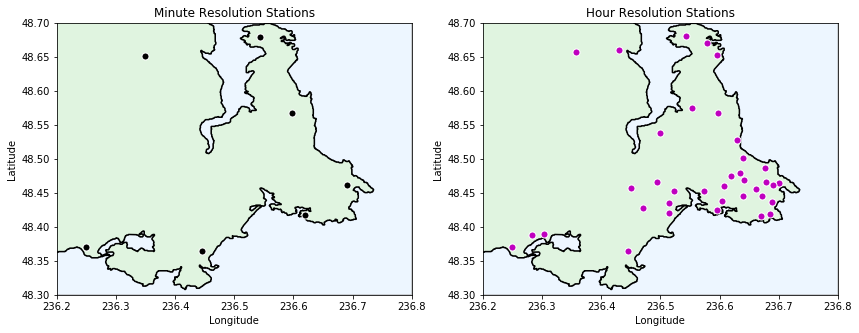

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(coast_lon, coast_lat, color='k')
ax[1].plot(coast_lon, coast_lat, color='k')

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='#DDEEFF', edgecolor='0.5', alpha=0.5)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T, facecolor='#CCEECC', edgecolor='0.5', alpha=0.6)
ax[0].add_patch(poly1)
ax[0].add_patch(poly2)

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='#DDEEFF', edgecolor='0.5', alpha=0.5)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T, facecolor='#CCEECC', edgecolor='0.5', alpha=0.6)
ax[1].add_patch(poly1)
ax[1].add_patch(poly2)

ax[0].scatter(min_longitudes, min_latitudes, s=50, color='k',  edgecolor='white', zorder=100)
ax[1].scatter(hour_longitudes, hour_latitudes, s=50, color='m',  edgecolor='white', zorder=100)

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Minute Resolution Stations')

ax[0].set_xlim((236.2, 236.8))
ax[0].set_ylim((48.3, 48.7))

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Hour Resolution Stations')

ax[1].set_xlim((236.2, 236.8))
ax[1].set_ylim((48.3, 48.7))

plt.savefig("plots/station_map", bbox_inches='tight', dpi=300)
plt.show()

# Make Map for Temperature Extrema

In [10]:
winter_hot_stats = np.array([station_num_to_location[i] for i in [15, 23, 24]])
winter_cold_stats = np.array([station_num_to_location[i] for i in [11, 30]])

summer_hot_stats = np.array([station_num_to_location[i] for i in [0, 7, 11, 13, 19]])
summer_cold_stats = np.array([station_num_to_location[i] for i in [9, 15, 22, 24]])

In [11]:
wint_hot_lon, wint_hot_lat, = zip(*winter_hot_stats)
wint_cold_lon, wint_cold_lat, = zip(*winter_cold_stats)

sum_hot_lon, sum_hot_lat, = zip(*summer_hot_stats)
sum_cold_lon, sum_cold_lat, = zip(*summer_cold_stats)

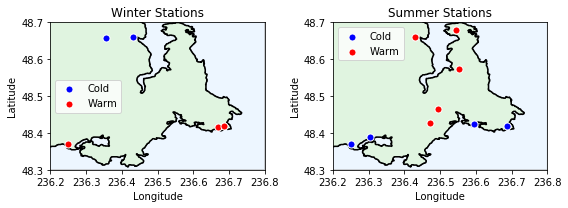

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(coast_lon, coast_lat, color='k')
ax[1].plot(coast_lon, coast_lat, color='k')

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T,
                facecolor='#DDEEFF', edgecolor='0.5', alpha=0.5)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T, facecolor='#CCEECC',
                edgecolor='0.5', alpha=0.6)
ax[0].add_patch(poly1)
ax[0].add_patch(poly2)

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T,
                facecolor='#DDEEFF', edgecolor='0.5', alpha=0.5)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T,
                facecolor='#CCEECC', edgecolor='0.5', alpha=0.6)

ax[1].add_patch(poly1)
ax[1].add_patch(poly2)

ax[0].scatter(wint_cold_lon, wint_cold_lat, s=50, color='b',  edgecolor='white',
              zorder=100, label='Cold')
ax[0].scatter(wint_hot_lon, wint_hot_lat, s=50, color='r',  edgecolor='white',
              zorder=100, label='Warm')

ax[1].scatter(sum_cold_lon, sum_cold_lat, s=50, color='b',
              edgecolor='white', zorder=100, label='Cold')
ax[1].scatter(sum_hot_lon, sum_hot_lat, s=50, color='r',
              edgecolor='white', zorder=100, label='Warm')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Winter Stations')

ax[0].set_xlim((236.2, 236.8))
ax[0].set_ylim((48.3, 48.7))

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Summer Stations')

ax[1].set_xlim((236.2, 236.8))
ax[1].set_ylim((48.3, 48.7))

ax[0].legend()
ax[1].legend()

fig.tight_layout()
plt.savefig("plots/extreme_stations", bbox_inches='tight', dpi=300)
plt.show()

# Standard Deviation Extrema

In [13]:
winter_large_stats = np.array([station_num_to_location[i] for i in [11, 30]])
winter_small_stats = np.array([station_num_to_location[i] for i in [12, 34]])

summer_large_stats = np.array([station_num_to_location[i] for i in [0, 1, 6, 11, 13, 30, 36]])
summer_small_stats = np.array([station_num_to_location[i] for i in [5, 10, 22, 23, 24, 32]])

In [14]:
wint_big_lon, wint_big_lat, = zip(*winter_large_stats)
wint_sma_lon, wint_sma_lat, = zip(*winter_small_stats)

sum_big_lon, sum_big_lat, = zip(*summer_large_stats)
sum_sma_lon, sum_sma_lat, = zip(*summer_small_stats)

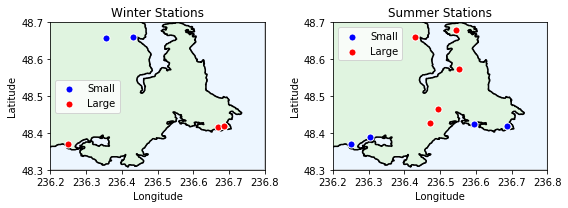

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))

ax[0].plot(coast_lon, coast_lat, color='k')
ax[1].plot(coast_lon, coast_lat, color='k')

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T,
                facecolor='#DDEEFF', edgecolor='0.5', alpha=0.5)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T, facecolor='#CCEECC',
                edgecolor='0.5', alpha=0.6)
ax[0].add_patch(poly1)
ax[0].add_patch(poly2)

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T,
                facecolor='#DDEEFF', edgecolor='0.5', alpha=0.5)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T,
                facecolor='#CCEECC', edgecolor='0.5', alpha=0.6)

ax[1].add_patch(poly1)
ax[1].add_patch(poly2)

ax[0].scatter(wint_cold_lon, wint_cold_lat, s=50, color='b',  edgecolor='white',
              zorder=100, label='Small')
ax[0].scatter(wint_hot_lon, wint_hot_lat, s=50, color='r',  edgecolor='white',
              zorder=100, label='Large')

ax[1].scatter(sum_cold_lon, sum_cold_lat, s=50, color='b',
              edgecolor='white', zorder=100, label='Small')
ax[1].scatter(sum_hot_lon, sum_hot_lat, s=50, color='r',
              edgecolor='white', zorder=100, label='Large')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Winter Stations')

ax[0].set_xlim((236.2, 236.8))
ax[0].set_ylim((48.3, 48.7))

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Summer Stations')

ax[1].set_xlim((236.2, 236.8))
ax[1].set_ylim((48.3, 48.7))

ax[0].legend()
ax[1].legend()

fig.tight_layout()
plt.savefig("plots/extreme_stations_std", bbox_inches='tight', dpi=300)
plt.show()

# Mean and Standard Deviation

### 2017

In [88]:
df_win = pd.read_pickle('Dataframes/winter_2017_means_stds')
df_sum = pd.read_pickle('Dataframes/summer_2017_means_stds')

wint_pnt_size = 2**(10*df_win['Std']/df_win['Std'].max())/5
sum_pnt_size = 2**(10*df_sum['Std']/df_sum['Std'].max())/5

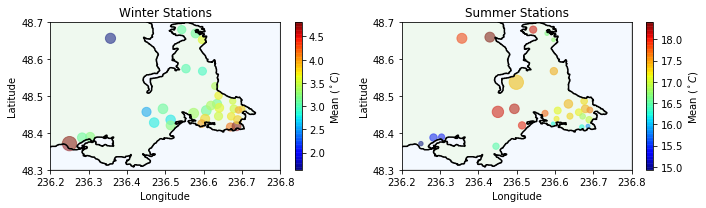

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

ax[0].plot(coast_lon, coast_lat, color='k')
ax[1].plot(coast_lon, coast_lat, color='k')

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T,
                facecolor='#DDEEFF', edgecolor='0.5', alpha=0.3)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T, facecolor='#CCEECC',
                edgecolor='0.5', alpha=0.3)
ax[0].add_patch(poly1)
ax[0].add_patch(poly2)

poly1 = Polygon(np.array([water_poly_lon, water_poly_lat]).T,
                facecolor='#DDEEFF', edgecolor='0.5', alpha=0.3)
poly2 = Polygon(np.array([coast_lon, coast_lat]).T,
                facecolor='#CCEECC', edgecolor='0.5', alpha=0.3)

ax[1].add_patch(poly1)
ax[1].add_patch(poly2)

s = ax[0].scatter(x=df_win['Longitude'], y=df_win['Latitude'], alpha=0.7,
                 s=wint_pnt_size, c=df_win['Mean'], cmap=plt.get_cmap('jet'))
cb = plt.colorbar(s, ax=ax[0])
cb.set_label('Mean ($^\circ C$)')

s = ax[1].scatter(x=df_sum['Longitude'], y=df_sum['Latitude'], alpha=0.7,
                 s=sum_pnt_size, c=df_sum['Mean'], cmap=plt.get_cmap('jet'))
cb = plt.colorbar(s, ax=ax[1])
cb.set_label('Mean ($^\circ C$)')


ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Winter Stations')

ax[0].set_xlim((236.2, 236.8))
ax[0].set_ylim((48.3, 48.7))

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Summer Stations')

ax[1].set_xlim((236.2, 236.8))
ax[1].set_ylim((48.3, 48.7))

fig.tight_layout()
plt.savefig("plots/extreme_stations_mean_std_2017", bbox_inches='tight', dpi=300)
plt.show()